In [1]:
# WEBSCRAPING
# FINAL

import requests
from bs4 import BeautifulSoup
import json

webscraped_data = []

url = "https://ppp.gov.ph/project-database/"
response = requests.get(url)
page_text = response.text
soup = BeautifulSoup(page_text)
selector = "body > div:nth-child(7) > div.large-9.medium-8.columns.center > div.large-6.columns.map-result > table"
view_content_element = soup.select(selector)[0]
new_selector = "tbody > tr"
table_rows = view_content_element.select(new_selector)


for tr in table_rows:
    
    # MAIN PAGE
    cols = tr.find_all('td')
    title_selector = cols[0]
    title = title_selector.text
    region_selector = cols[1]
    region = region_selector.text
    sector_selector = cols[2]
    sector = sector_selector.text
    status_selector = cols[3]
    status = status_selector.text.split(",")[0]
    try:
        award = status_selector.text.split(",")[1]
    except:
        award = None
    agent_selector = cols[4]
    agent = agent_selector.text
    
    page_data = {}
    
    page_data["Project Title"] = title
    page_data["Region"] = region
    page_data["Sector"] = sector
    page_data["Status"] = status
    page_data["Award"] = award
    page_data["Implementing Agency"] = agent
    
    # EACH SITE -> get cost
    rows = tr.find("a")
    ref = rows.get("href")
    
    new_resp = requests.get(ref)
    c_text = new_resp.text
    c_soup = BeautifulSoup(c_text)
    b_selector = "body > div:nth-child(7) > div.large-9.medium-8.columns.center > div.su-accordion > div > div > div.su-spoiler-content.su-clearfix"
    view_body = c_soup.select(b_selector)[0]

    c = view_body.find_all("p")
    
    try:
        priority = [3,4,5,6,7,8,2,9,10,11]
        for p in priority:
            if c[p].text.strip().lower().find("php") == 0 or c[p].text.strip().lower().find("usd") == 0 or c[p].text.strip().lower().find("million") > 0 or c[p].text.strip().lower().find("billion") > 0 or c[p].text.strip().lower().find("milion") > 0 or c[p].text.strip().lower().find("bilion") > 0 or c[p].text.strip().lower().find("-") == 0 or c[p].text.strip().lower().find("tbd") == 0 or c[p].text.strip().lower().find("for validation") == 0:
                project_cost = c[p].text.strip()
                break
    except:
        project_cost = "Not Indicated" 
    
    page_data["Cost"] = project_cost
    
    webscraped_data.append(page_data)

# SPECIAL CASES 
webscraped_data[7]["Award"] = webscraped_data[7]["Status"] # switched value cos no status indicated in the og site
webscraped_data[7]["Status"] = "Unknown"
webscraped_data[209]["Cost"] = "PhP 12.55 Billion" # gets the wrong text cos there was an instance where "million" was in the first text and it printed that immediately but the correct text is the next instance 

print(webscraped_data)    

with open("complete_data.json", "w") as complete: 
    json.dump(webscraped_data, complete, indent = 4)


[{'Project Title': 'PPP for School Infrastructure Project Phase II (PSIP II) – Package E', 'Region': 'REGION X - NORTHERN MINDANAO,CARAGA', 'Sector': 'Education', 'Status': 'Under Construction', 'Award': 'Awarded', 'Implementing Agency': 'Department of Education (DepEd)', 'Cost': 'Php 1,604.59 Million'}, {'Project Title': 'PPP for School Infrastructure Project Phase I (PSIP I) – Package C', 'Region': 'REGION IV-A - CALABARZON', 'Sector': 'Education', 'Status': 'Operational', 'Award': 'Awarded', 'Implementing Agency': 'Department of Education (DepEd)', 'Cost': 'Php 7,604.90 Million'}, {'Project Title': 'PPP for School Infrastructure Project Phase I (PSIP I) – Package B', 'Region': 'REGION III - CENTRAL LUZON', 'Sector': 'Education', 'Status': 'Operational', 'Award': 'Awarded', 'Implementing Agency': 'Department of Education (DepEd)', 'Cost': 'Php 5,229.90 Million'}, {'Project Title': 'Tri-City Ferry System Project', 'Region': 'REGION I - ILOCOS', 'Sector': 'Transportation,Ferry', 'Statu

In [2]:
# Data Cleansing

import pandas as pd
import re

cr_df = pd.read_json('./complete_data.json')

def convert_cost(cost_str):
    import difflib
    
    s = cost_str.lower()
    if s != '-' and s != 'tbd':
        s = re.sub('[a-zA-Z]','',s)
        s = s.replace(",","")
        indicator = '.'
        if indicator in s:
            cost = re.findall("\d+\.\d+", s)
        else:
            cost = re.findall("[0-9]+", s)
    else:
        cost = s
        
    if cost_str.endswith("M") or cost_str.endswith("m"):
        return float(cost[0]) * 1000000
 
    end = re.findall('[a-zA-Z]+'+r'on\b', cost_str)
    measures = {'billion':1000000000,'million':1000000,'m':1000000}
    if cost in ['tbd', '-'] or len(cost) == 0:
        return None
    elif len(end) > 0:
        num = cost[0]
        fixed_measure = difflib.get_close_matches(end[0].lower(), ['billion','million','m'])[0]
        return float(num) * measures[fixed_measure]
    else:
        num = ''.join(cost).replace(',','')
        return float(num)
    
def get_currency(cost):
    if cost in ["TBD", "Not Indicated"]:
        return cost
    
    import difflib
    cost = cost.lower()
    cost = re.sub('\d+[,.]*', '', cost)
    word = cost.split()[0]
    if word not in ['tbd','-','not']:
        if len(difflib.get_close_matches(word, ['us','$','php'])) != 0:
            curr = {'us':'USD','$':'USD','php':'PHP'}
            return curr[difflib.get_close_matches(word, ['us','$','php'])[0]]
        else:
            return None
    else:
        return None

def get_cost(data):
    currency = data['Currency']
    
    if currency in ["TBD", "Not Indicated"]:
        return currency
    
    numerical = data['Numerical Cost']
    
    if numerical == None or pd.isnull(numerical):
        return '-'
    
    if currency == 'USD':
        numerical *= 50.54  

    numerical = f"{numerical:,.2f}"
    return 'PHP ' + numerical
        
    
# Debugger
'''for i,s in enumerate(cr_df['Cost']):
    print(f'\nIndex {i}')
    try:
        convert_cost(s)
        get_currency(s)
    except:
        print(f'Error')'''

cr_df['Numerical Cost'] = cr_df['Cost'].apply(convert_cost)
cr_df['Currency'] = cr_df['Cost'].apply(get_currency)

cr_df['Cost (PHP)'] = cr_df[['Numerical Cost', 'Currency']].apply(get_cost, axis=1)

pd.set_option('display.max_rows', None)
display(cr_df)

Project Title  \
0    PPP for School Infrastructure Project Phase II...   
1    PPP for School Infrastructure Project Phase I ...   
2    PPP for School Infrastructure Project Phase I ...   
3                        Tri-City Ferry System Project   
4                        Metro Manila Skyway (Stage 2)   
5    San Pablo City Water District Septage Manageme...   
6                    MWSS Privatization Project (East)   
7    Joint Venture Agreement for the Development an...   
8                  Modernization of Cebu Carbon Market   
9    Municipality of Malay Ecological Solid Waste M...   
10            Quezon City Central Post Office (QC-CPO)   
11               Davao No Contact Apprehension Project   
12   TIEZA Clark Tourism Enterprise Zone (TEZ) Project   
13   Operations and Maintenance of the North-South ...   
14   Metro Manila Subway Project (MMSP) Operations ...   
15   Unsolicited Proposal for the Port of General S...   
16                     Dagupan Waste-to-Energy Project   
17   Joint-Venture Agreement for the Puerto Princes...   
18   Joint Venture Agreement for the Provision of S...   
19   Joint Venture Agreement for the Financing, Dev...   
20   Joint Venture Agreement for the Financing, Imp...   
21   Joint Venture Agreement for the Financing, Dev...   
22   Joint Venture Agreement for the Financing, Dev...   
23   Joint Venture Agreement for the Financing, Dev...   
24   Joint Venture Agreement for the Financing, Dev...   
25   Joint Venture Agreement for the Financing, Dev...   
26   Joint Venture Agreement for the Financing, Dev...   
27   Joint Venture Agreement for the Financing, Dev...   
28   Joint Venture Agreement for the Financing, Dev...   
29   Joint Venture Agreement for the Financing, Dev...   
30   Joint Venture Agreement for the Financing, Dev...   
31   Joint Venture Agreement for the Financing, Dev...   
32   Joint Venture Agreement for the Financing, Dev...   
33   Joint Venture Agreement for the Financing, Dev...   
34   Joint Venture Agreement for the Financing, Dev...   
35   Joint Venture Agreement for the Financing, Dev...   
36   Joint Venture Agreement for the Financing, Dev...   
37   Joint Venture Agreement for the Financing, Dev...   
38   Joint Venture Agreement for the Financing, Dev...   
39   Joint Venture Agreement for the Financing, Dev...   
40   Joint Venture Agreement for the Financing, Dev...   
41   Joint Venture Agreement for the Financing, Dev...   
42   Joint Venture Agreement for the Financing, Dev...   
43   Joint Venture Agreement for the Financing, Dev...   
44   Joint Venture Agreement for the Financing, Dev...   
45   Joint Venture Agreement for the Establishment,...   
46   Joint Venture Agreement for the Financing, Dev...   
47    Joint-Venture Project on Bulk Water Supply (JV1)   
48   Joint-Venture Project on Water Distribution (JV2)   
49   Lingayen Water District Joint-Venture Agreemen...   
50   New Clark City – Mixed Use Industrial Real Est...   
51       Parañaque City Mixed-Used Development Project   
52   NLEX Harbor Link Project (Segments 8.1, 8.2, 9...   
53   Joint Venture Agreement for the Financing, Dev...   
54                Redevelopment of City Slaughterhouse   
55   Southeast Metro Manila Expressway (SEMME) (C6 ...   
56            Tagum City Waste-to-Energy Plant Project   
57   Water Supply Facility and Bulk Water Delivery ...   
58    Zamboanga City Water District Bulk Water Project   
59   Financing, Development, Rehabilitation, Expans...   
60   Expansion of Water Lines, Reservoir and Source...   
61   Establishment and Operation of the San Simon W...   
62   Concession Agreement for the Cauayan City Ente...   
63           Construction of 30 Units Commercial Stall   
64    City of Ilagan Water District Bulk Water Project   
65                 Boracay Water Joint Venture Project   
66   Expansion, Operation and Maintenance of Vessel...   
67     New Metro Manila Food and Transport Hub Project   
68                               Metro 

In [3]:
# Data Sorting

statuses = cr_df.Status.unique()

for status in statuses:
    df = cr_df.loc[cr_df["Status"] == status]
    sectors = df['Sector'].value_counts().index.tolist()

    new_df = pd.DataFrame(columns=list(df.columns))
    for sector in sectors:
        projects = df.loc[df["Sector"] == sector]
        projects = projects.sort_values('Numerical Cost', ascending=False)
        new_df = pd.concat([new_df, projects])
    
    final_df = new_df.filter(["Sector", "Project Title", "Implementing Agency", "Cost (PHP)", "Region", "Award"], axis=1)
    
    final_df = final_df.style.set_caption(status).set_table_styles([{
            'selector': 'caption',
            'props': [
                ('color', 'black'),
                ('font-size', '24px')
            ]
        }])
    final_df = final_df.hide_index()
    
    display(final_df)

In [4]:
 # Data Cleansing

import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

cr_df = pd.read_json('./complete_data.json')

def convert_cost(cost_str):
    import difflib
    
    s = cost_str.lower()
    if s != '-' and s != 'tbd':
        s = re.sub('[a-zA-Z]','',s)
        s = s.replace(",","")
        indicator = '.'
        if indicator in s:
            cost = re.findall("\d+\.\d+", s)
        else:
            cost = re.findall("[0-9]+", s)
    else:
        cost = s
        
    if cost_str.endswith("M") or cost_str.endswith("m"):
        return float(cost[0]) * 1000000
 
    end = re.findall('[a-zA-Z]+'+r'on\b', cost_str)
    measures = {'billion':1000000000,'million':1000000,'m':1000000}
    if cost in ['tbd', '-'] or len(cost) == 0:
        return None
    elif len(end) > 0:
        num = cost[0]
        fixed_measure = difflib.get_close_matches(end[0].lower(), ['billion','million','m'])[0]
        return float(num) * measures[fixed_measure]
    else:
        num = ''.join(cost).replace(',','')
        return float(num)
    
def get_currency(cost):
    if cost in ["TBD", "Not Indicated"]:
        return cost
    
    import difflib
    cost = cost.lower()
    cost = re.sub('\d+[,.]*', '', cost)
    word = cost.split()[0]
    if word not in ['tbd','-','not']:
        if len(difflib.get_close_matches(word, ['us','$','php'])) != 0:
            curr = {'us':'USD','$':'USD','php':'PHP'}
            return curr[difflib.get_close_matches(word, ['us','$','php'])[0]]
        else:
            return None
    else:
        return None

def get_cost(data):
    currency = data['Currency']
    
    if currency in ["TBD", "Not Indicated"]:
        return currency
    
    numerical = data['Numerical Cost']
    
    if numerical == None or pd.isnull(numerical):
        return '-'
    
    if currency == 'USD':
        numerical *= 50.54  

    numerical = f"{numerical:,.2f}"
    return 'PHP ' + numerical
        
    
# Debugger
'''for i,s in enumerate(cr_df['Cost']):
    print(f'\nIndex {i}')
    try:
        convert_cost(s)
        get_currency(s)
    except:
        print(f'Error')'''

cr_df['Numerical Cost'] = cr_df['Cost'].apply(convert_cost)
cr_df['Currency'] = cr_df['Cost'].apply(get_currency)

cr_df['Cost (PHP)'] = cr_df[['Numerical Cost', 'Currency']].apply(get_cost, axis=1)

pd.set_option('display.max_rows', None)
display(cr_df)

Project Title  \
0    PPP for School Infrastructure Project Phase II...   
1    PPP for School Infrastructure Project Phase I ...   
2    PPP for School Infrastructure Project Phase I ...   
3                        Tri-City Ferry System Project   
4                        Metro Manila Skyway (Stage 2)   
5    San Pablo City Water District Septage Manageme...   
6                    MWSS Privatization Project (East)   
7    Joint Venture Agreement for the Development an...   
8                  Modernization of Cebu Carbon Market   
9    Municipality of Malay Ecological Solid Waste M...   
10            Quezon City Central Post Office (QC-CPO)   
11               Davao No Contact Apprehension Project   
12   TIEZA Clark Tourism Enterprise Zone (TEZ) Project   
13   Operations and Maintenance of the North-South ...   
14   Metro Manila Subway Project (MMSP) Operations ...   
15   Unsolicited Proposal for the Port of General S...   
16                     Dagupan Waste-to-Energy Project   
17   Joint-Venture Agreement for the Puerto Princes...   
18   Joint Venture Agreement for the Provision of S...   
19   Joint Venture Agreement for the Financing, Dev...   
20   Joint Venture Agreement for the Financing, Imp...   
21   Joint Venture Agreement for the Financing, Dev...   
22   Joint Venture Agreement for the Financing, Dev...   
23   Joint Venture Agreement for the Financing, Dev...   
24   Joint Venture Agreement for the Financing, Dev...   
25   Joint Venture Agreement for the Financing, Dev...   
26   Joint Venture Agreement for the Financing, Dev...   
27   Joint Venture Agreement for the Financing, Dev...   
28   Joint Venture Agreement for the Financing, Dev...   
29   Joint Venture Agreement for the Financing, Dev...   
30   Joint Venture Agreement for the Financing, Dev...   
31   Joint Venture Agreement for the Financing, Dev...   
32   Joint Venture Agreement for the Financing, Dev...   
33   Joint Venture Agreement for the Financing, Dev...   
34   Joint Venture Agreement for the Financing, Dev...   
35   Joint Venture Agreement for the Financing, Dev...   
36   Joint Venture Agreement for the Financing, Dev...   
37   Joint Venture Agreement for the Financing, Dev...   
38   Joint Venture Agreement for the Financing, Dev...   
39   Joint Venture Agreement for the Financing, Dev...   
40   Joint Venture Agreement for the Financing, Dev...   
41   Joint Venture Agreement for the Financing, Dev...   
42   Joint Venture Agreement for the Financing, Dev...   
43   Joint Venture Agreement for the Financing, Dev...   
44   Joint Venture Agreement for the Financing, Dev...   
45   Joint Venture Agreement for the Establishment,...   
46   Joint Venture Agreement for the Financing, Dev...   
47    Joint-Venture Project on Bulk Water Supply (JV1)   
48   Joint-Venture Project on Water Distribution (JV2)   
49   Lingayen Water District Joint-Venture Agreemen...   
50   New Clark City – Mixed Use Industrial Real Est...   
51       Parañaque City Mixed-Used Development Project   
52   NLEX Harbor Link Project (Segments 8.1, 8.2, 9...   
53   Joint Venture Agreement for the Financing, Dev...   
54                Redevelopment of City Slaughterhouse   
55   Southeast Metro Manila Expressway (SEMME) (C6 ...   
56            Tagum City Waste-to-Energy Plant Project   
57   Water Supply Facility and Bulk Water Delivery ...   
58    Zamboanga City Water District Bulk Water Project   
59   Financing, Development, Rehabilitation, Expans...   
60   Expansion of Water Lines, Reservoir and Source...   
61   Establishment and Operation of the San Simon W...   
62   Concession Agreement for the Cauayan City Ente...   
63           Construction of 30 Units Commercial Stall   
64    City of Ilagan Water District Bulk Water Project   
65                 Boracay Water Joint Venture Project   
66   Expansion, Operation and Maintenance of Vessel...   
67     New Metro Manila Food and Transport Hub Project   
68                               Metro 

In [12]:
total_costs=pd.DataFrame(cr_df['Numerical Cost'].sum(), index = ["Total Costs for all Projects"], columns=["Numerical Cost (Php)"])
total_costs['Numerical Cost (Php)']=total_costs['Numerical Cost (Php)'].astype('int64')
total_costs['Numerical Cost (Php)']=total_costs.apply(lambda x:"{:,}".format(x['Numerical Cost (Php)']), axis=1)

total_costs

Numerical Cost (Php)
Total Costs for all Projects   27,688,421,035,295

In [14]:
category = list(set(cr_df['Status']))

table=[]
for i in category:
    table.append(pd.DataFrame(cr_df.loc[(cr_df['Status'] == i), 'Numerical Cost'].sum(), index = [i], 
                              columns=['Total Cost (PHP)']))

result1=table[0]
for i in range(1,len(table)):
    result1=result1.append(table[i])
    result1['Total Cost (PHP)']=result1['Total Cost (PHP)'].astype('int64')
    
final_table=result1.sort_values(by=['Total Cost (PHP)'], ascending=False)
final_table['Total Cost (PHP)']=final_table.apply(lambda x:"{:,}".format(x['Total Cost (PHP)']), axis=1)

styled_table=final_table.style.set_caption('Costs Under Project Status').set_table_styles([{
    'selector':'caption',
    'props':[
        ('color','black'),
        ('font-size','18px')
    ]
}])

display(styled_table)

In [13]:
status = list(set(cr_df['Status']))

status_table=[]
for i in status:
    status_table.append(pd.DataFrame(cr_df.loc[(cr_df['Status'] == i), 'Numerical Cost'].mean(), index = [i], columns=["Average Cost (PHP)"]))

result=status_table[0]
for i in range(1,len(status_table)):
    result=result.append(status_table[i])
    result['Average Cost (PHP)']=result['Average Cost (PHP)'].astype('int64')
    
final_table=result.sort_values(by=['Average Cost (PHP)'], ascending=False)
final_table['Average Cost (PHP)']=final_table.apply(lambda x:"{:,}".format(x['Average Cost (PHP)']), axis=1)

styled_table=final_table.style.set_caption('Average Costs Under Project Status').set_table_styles([{
    'selector':'caption',
    'props':[
        ('color','black'),
        ('font-size','18px')
    ]
}])

display(styled_table)

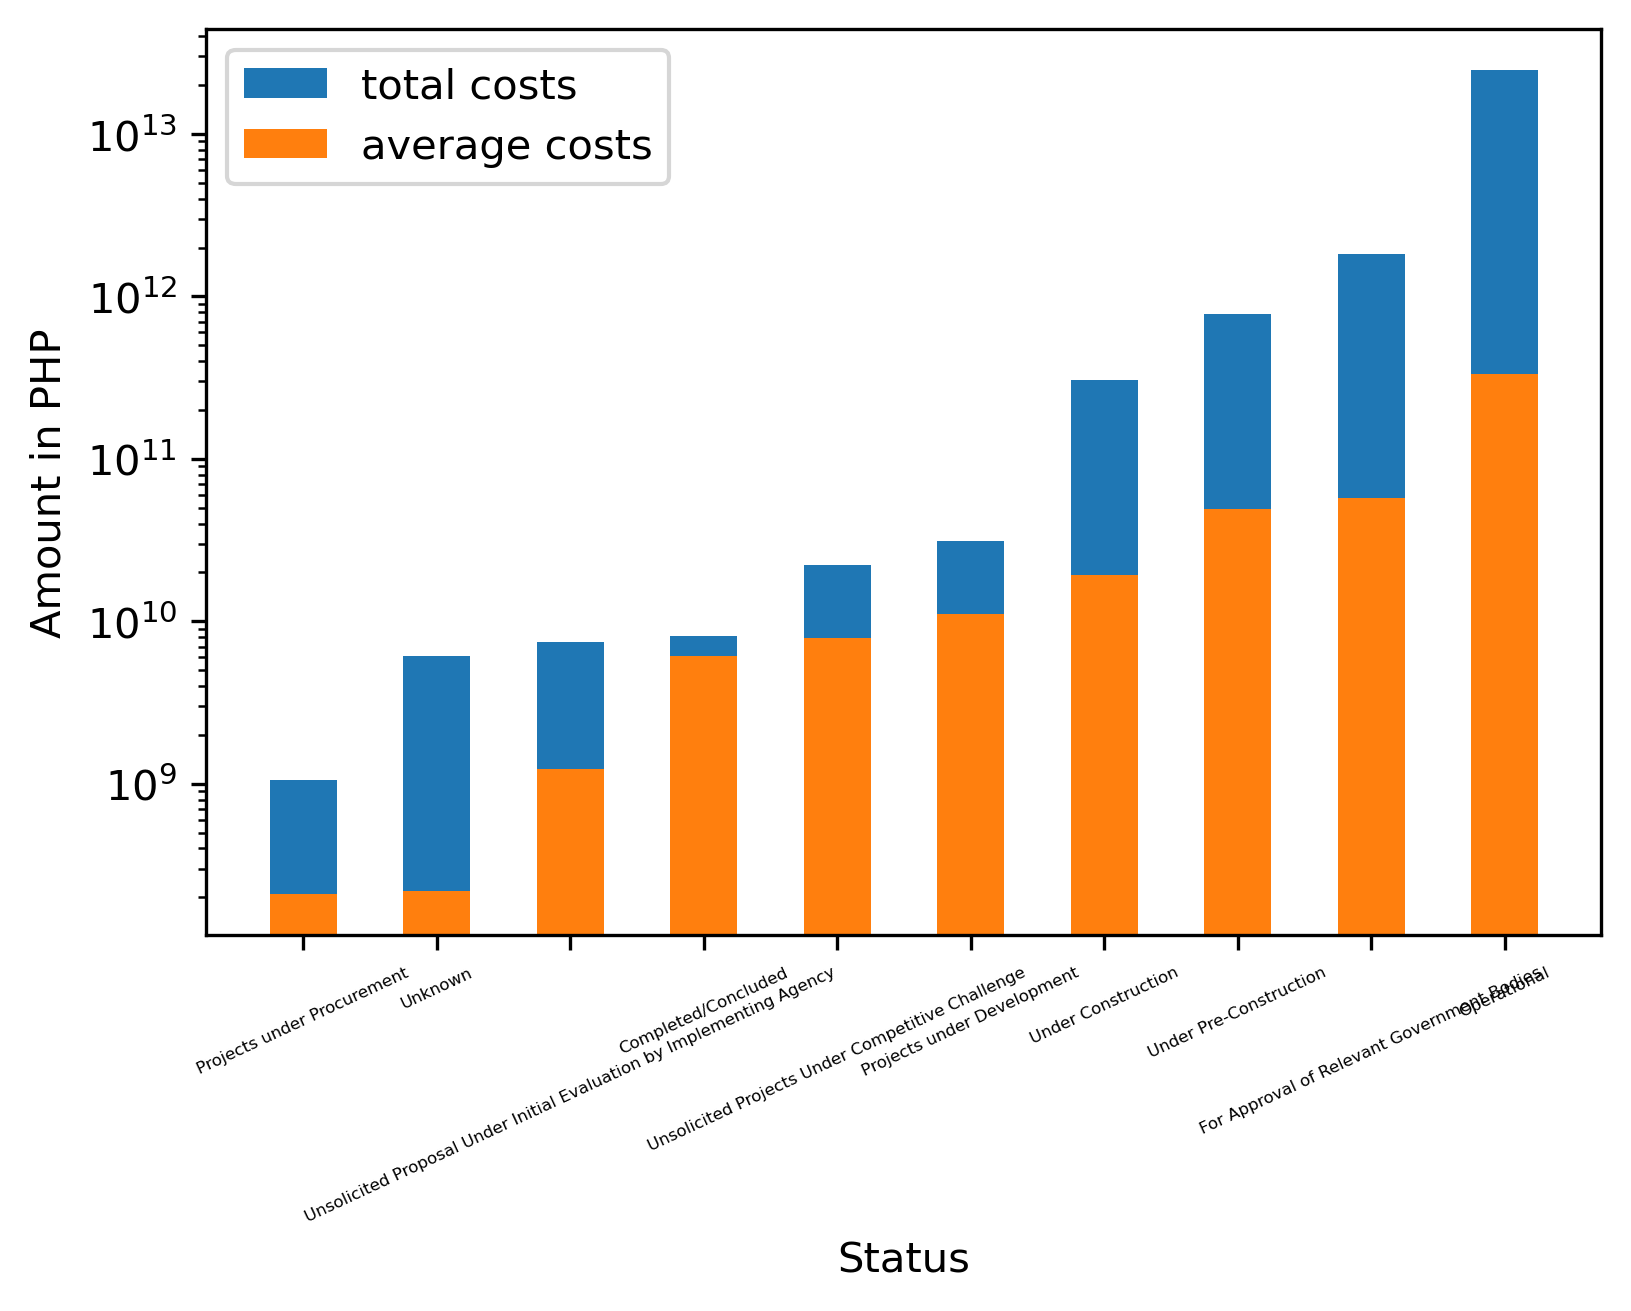

In [15]:
import matplotlib
import numpy as np

final_table=result1.sort_values(by=['Total Cost (PHP)'], ascending=True)
final_table1=result.sort_values(by=['Average Cost (PHP)'], ascending=True)

data=final_table.to_dict()['Total Cost (PHP)']
data1=final_table1.to_dict()['Average Cost (PHP)']
x=list(data.keys())
y=list(data.values())
z=list(data1.values())

w=0.5
plt.figure(dpi=300)
plt.bar(x,y,w,label="total costs")
plt.bar(x,z,w,label="average costs")

plt.xlabel("Status")
plt.ylabel("Amount in PHP")
plt.xticks(x, rotation=25, fontsize=4)
plt.yscale('log')
plt.legend()
plt.show()

In [19]:
sectors = list(set(cr_df['Sector']))

sectors_table=[]
for i in sectors:
    sectors_table.append(pd.DataFrame(cr_df.loc[(cr_df['Sector'] == i), 'Numerical Cost'].sum(), index = [i], columns=["Total Cost (PHP)"]))

result=sectors_table[0]
for i in range(1,len(sectors_table)):
    result=result.append(sectors_table[i])
    result['Total Cost (PHP)']=result['Total Cost (PHP)'].astype('int64')


final_table=result.sort_values(by=['Total Cost (PHP)'], ascending=False)
final_table['Total Cost (PHP)']=final_table.apply(lambda x:"{:,}".format(x['Total Cost (PHP)']), axis=1)


final_table=final_table.style.set_caption('Costs Under Sectors').set_table_styles([{
    'selector':'caption',
    'props':[
        ('color','black'),
        ('font-size','18px')
    ]
}])
    
display(final_table)

In [9]:
sectors = list(set(cr_df['Sector']))

sectors_table=[]
for i in sectors:
    sectors_table.append(pd.DataFrame(cr_df.loc[(cr_df['Status'] == 'Operational') & (cr_df['Sector'] == i), 
                                                'Numerical Cost'].sum(), index = [i], columns=["Total Cost (PHP)"]))

result=sectors_table[0]
for i in range(1,len(sectors_table)):
    result=result.append(sectors_table[i])
    result['Total Cost (PHP)']=result['Total Cost (PHP)'].astype('int64')
    
final_table=result.sort_values(by=['Total Cost (PHP)'], ascending=False)
final_table['Total Cost (PHP)']=final_table.apply(lambda x:"{:,}".format(x['Total Cost (PHP)']), axis=1)


final_table=final_table.style.set_caption('Costs Under Operational Projects in Each Sectors').set_table_styles([{
    'selector':'caption',
    'props':[
        ('color','black'),
        ('font-size','18px')
    ]
}])
    
display(final_table)

In [20]:
sectors = list(set(cr_df['Sector']))

sectors_table=[]
for i in sectors:
    sectors_table.append(pd.DataFrame(cr_df.loc[(cr_df['Status'] == 'Operational') & (cr_df['Sector'] == i), 
                                                'Numerical Cost'].sum(), index = [i], columns=["Total Cost (PHP)"]))

sumresult=sectors_table[0]
for i in range(1,len(sectors_table)):
    sumresult=sumresult.append(sectors_table[i])
    sumresult['Total Cost (PHP)']= sumresult['Total Cost (PHP)']
    sumresult['Total Cost (PHP)']=sumresult['Total Cost (PHP)']
    
final_table=sumresult.sort_values(by=['Total Cost (PHP)'], ascending=False)
final_table['Total Cost (PHP)']=final_table.apply(lambda x:"{:,}".format(x['Total Cost (PHP)']), axis=1)


final_table=final_table.style.set_caption('Total Costs Under Operational Projects in Each Sectors').set_table_styles([{
    'selector':'caption',
    'props':[
        ('color','black'),
        ('font-size','18px')
    ]
}])
    
display(final_table)

In [22]:
sectors = list(set(cr_df['Sector']))


cr_df['Numerical Cost']=cr_df['Numerical Cost'].replace({np.nan:0})
cr_df['Numerical Cost']=cr_df['Numerical Cost'].fillna(0)

sectors_table=[]
for i in sectors:
    sectors_table.append(pd.DataFrame(cr_df.loc[(cr_df['Status'] == 'Operational') & (cr_df['Sector'] == i), 
                                                'Numerical Cost'].mean(), index = [i], columns=["Average Cost (PHP)"]))

result=sectors_table[0]
for i in range(1,len(sectors_table)):
    result=result.append(sectors_table[i])
    result['Average Cost (PHP)']= result['Average Cost (PHP)'].fillna(0)
    result['Average Cost (PHP)']=result['Average Cost (PHP)'].round().astype(np.int64)
    
final_table=result.sort_values(by=['Average Cost (PHP)'], ascending=False)
final_table['Average Cost (PHP)']=final_table.apply(lambda x:"{:,}".format(x['Average Cost (PHP)']), axis=1)


final_table=final_table.style.set_caption('Average Costs Under Operational Projects in Each Sectors').set_table_styles([{
    'selector':'caption',
    'props':[
        ('color','black'),
        ('font-size','18px')
    ]
}])
    
display(final_table)

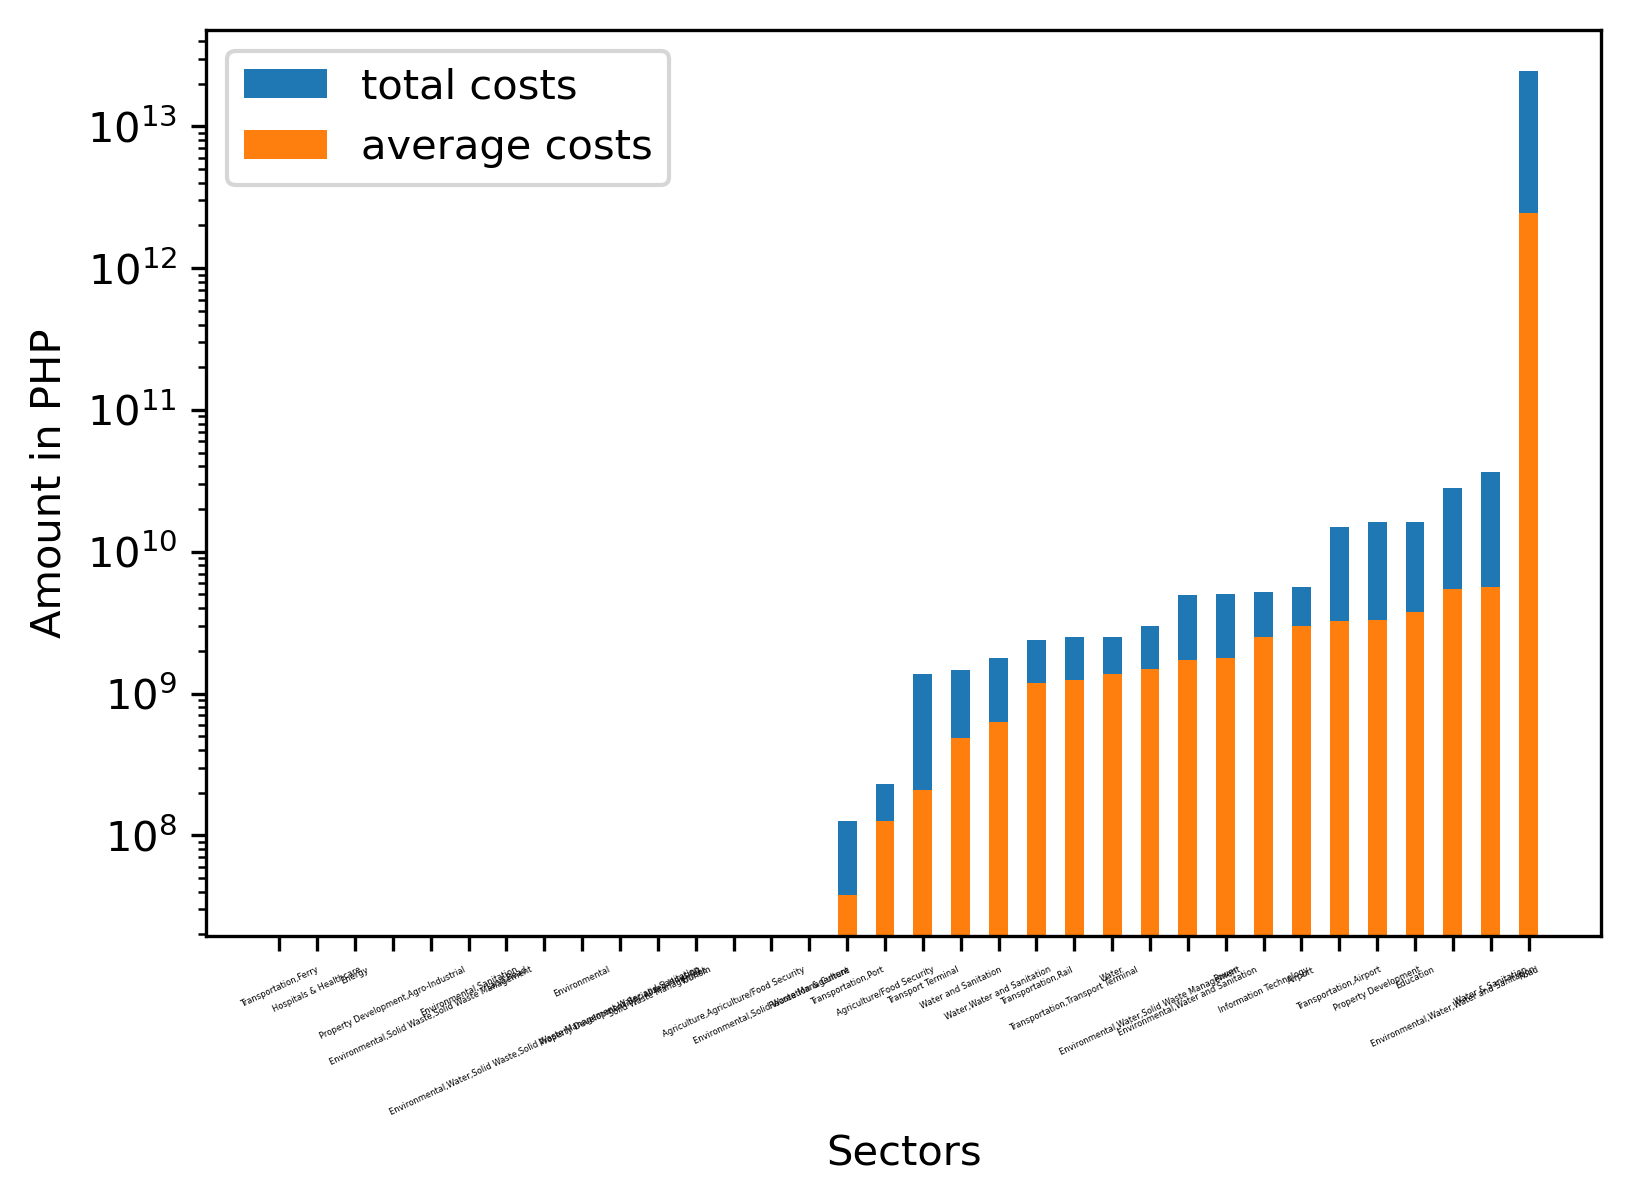

In [23]:
final_table=sumresult.sort_values(by=['Total Cost (PHP)'], ascending=True)
final_table1=result.sort_values(by=['Average Cost (PHP)'], ascending=True)

data=final_table.to_dict()['Total Cost (PHP)']
data1=final_table1.to_dict()['Average Cost (PHP)']
x=list(data.keys())
y=list(data.values())
z=list(data1.values())

w=0.5
plt.figure(dpi=300)
plt.bar(x,y,w,label="total costs")
plt.bar(x,z,w,label="average costs")

plt.xlabel("Sectors")
plt.ylabel("Amount in PHP")
plt.xticks(x, rotation=25, fontsize=2)
plt.yscale('log')
plt.legend()
plt.show()

In [24]:
sectors = list(set(cr_df['Sector']))

sectors_table=[]
for i in sectors:
    sectors_table.append(pd.DataFrame(cr_df.loc[(cr_df['Status'] == 'Completed/Concluded') & (cr_df['Sector'] == i), 
                                                'Numerical Cost'].sum(), index = [i], columns=["Total Cost (PHP)"]))

result=sectors_table[0]
for i in range(1,len(sectors_table)):
    result=result.append(sectors_table[i])
    result['Total Cost (PHP)']=result['Total Cost (PHP)'].astype('int64')
    
final_table=result.sort_values(by=['Total Cost (PHP)'], ascending=False)
final_table['Total Cost (PHP)']=final_table.apply(lambda x:"{:,}".format(x['Total Cost (PHP)']), axis=1)


final_table=final_table.style.set_caption('Costs Under Completed/Concluded Projects in Each Sectors').set_table_styles([{
    'selector':'caption',
    'props':[
        ('color','black'),
        ('font-size','18px')
    ]
}])
    
display(final_table)

In [11]:
regions = list(set(cr_df['Region']))

regions_table=[]
for i in regions:
    regions_table.append(pd.DataFrame(cr_df.loc[(cr_df['Region'] == i), 
                                                'Numerical Cost'].sum(), index = [i], columns=["Total Cost (PHP)"]))

result=regions_table[0]
for i in range(1,len(regions_table)):
    result=result.append(regions_table[i])
    result['Total Cost (PHP)']=result['Total Cost (PHP)'].astype('int64')
    
final_table=result.sort_values(by=['Total Cost (PHP)'], ascending=False)
final_table['Total Cost (PHP)']=final_table.apply(lambda x:"{:,}".format(x['Total Cost (PHP)']), axis=1)

final_table=final_table.style.set_caption('Costs Under Projects in Regions').set_table_styles([{
    'selector':'caption',
    'props':[
        ('color','black'),
        ('font-size','18px')
    ]
}])
    
display(final_table)

In [25]:

# Data Sorting

statuses = cr_df.Status.unique()

for status in statuses:
    df = cr_df.loc[cr_df["Status"] == status]
    sectors = df['Sector'].value_counts().index.tolist()

    new_df = pd.DataFrame(columns=list(df.columns))
    for sector in sectors:
        projects = df.loc[df["Sector"] == sector]
        projects = projects.sort_values('Numerical Cost', ascending=False)
        new_df = pd.concat([new_df, projects])
    
    final_df = new_df.filter(["Sector", "Project Title", "Implementing Agency", "Cost (PHP)", "Region", "Award"], axis=1)
    
    final_df = final_df.style.set_caption(status).set_table_styles([{
            'selector': 'caption',
            'props': [
                ('color', 'black'),
                ('font-size', '24px')
            ]
        }])
    final_df = final_df.hide_index()
    
    display(final_df)

In [26]:
import json
import pandas as pd
import matplotlib.pyplot as plt 

with open ('complete_data.json', 'r',) as graph_data:
    graph_data = json.loads(graph_data.read())

In [27]:
df= pd.DataFrame(graph_data)

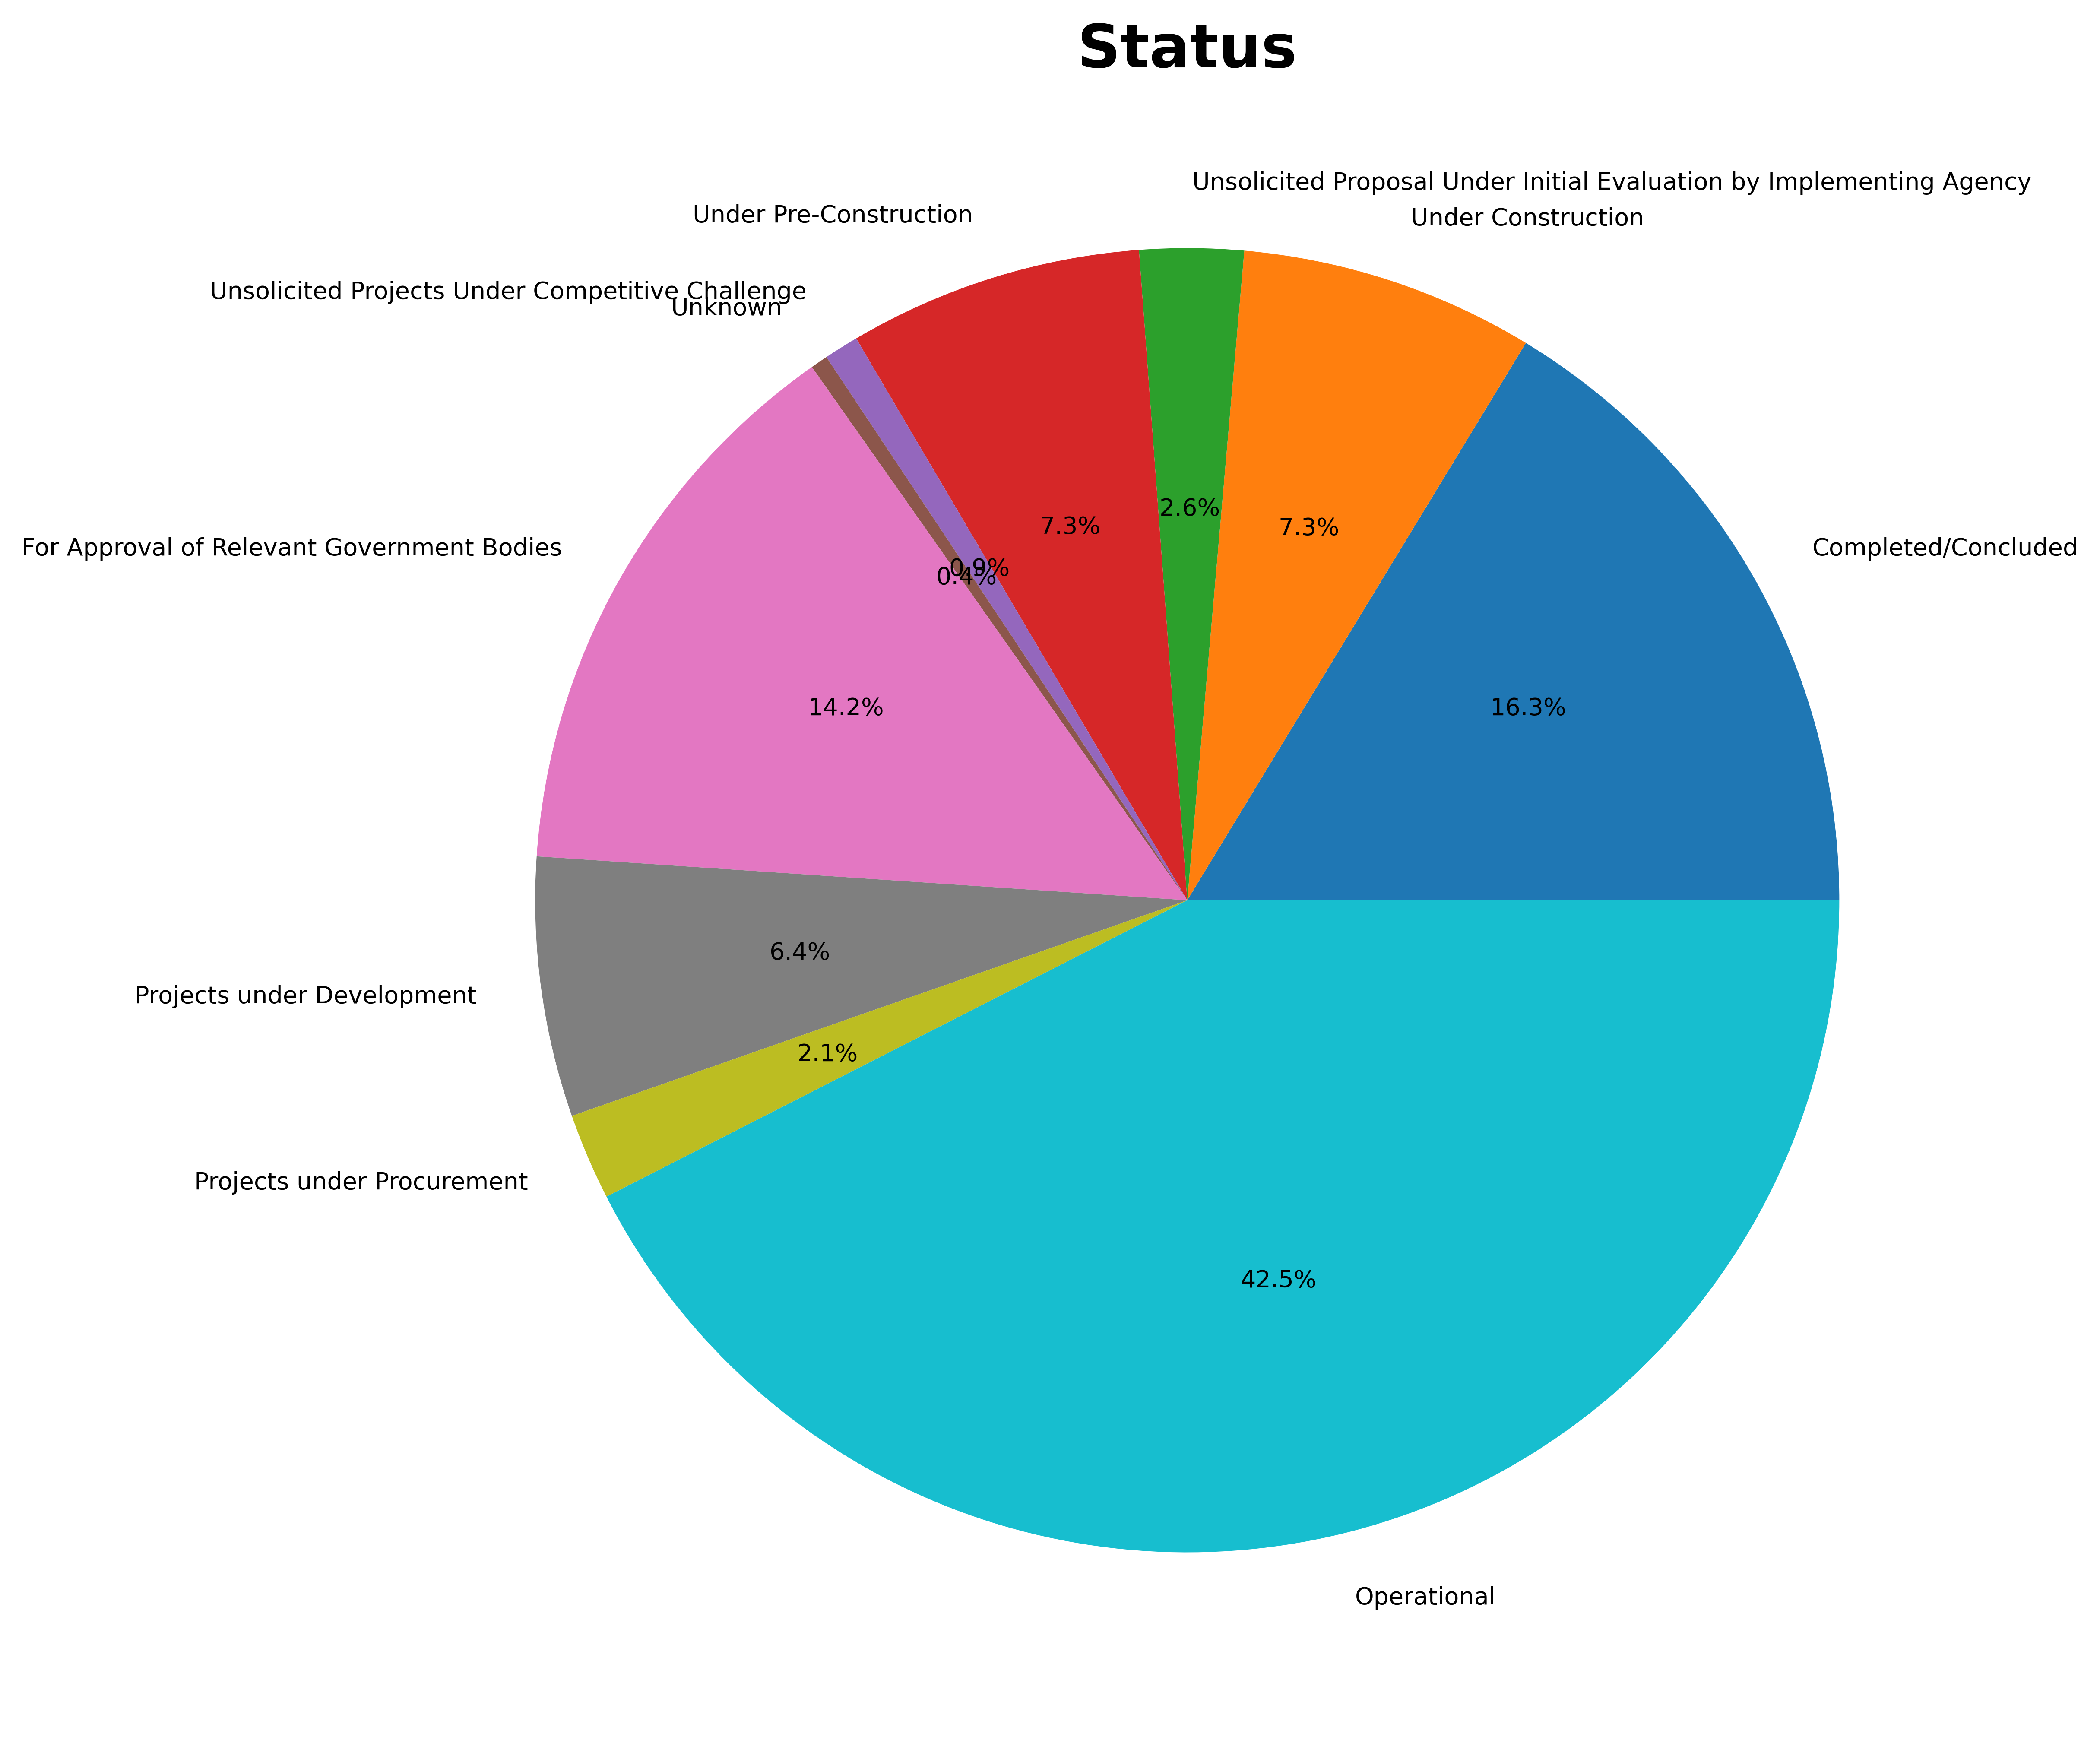

In [32]:
df= pd.DataFrame(graph_data)
sorted_category = list(set(df['Status']))

pie_data=[]
for i in sorted_category:
    pie_data.append(len(df.loc[(df['Status'] == i)]['Status']))

plt.figure(figsize=(10,10),dpi=500)
plt.title('Status', fontdict={'fontweight':'bold','fontsize':20})
plt.savefig('Status.png',dpi=500)
plt.pie(pie_data, labels=sorted_category,textprops={'fontsize':8}, autopct='%1.1f%%')
plt.show()

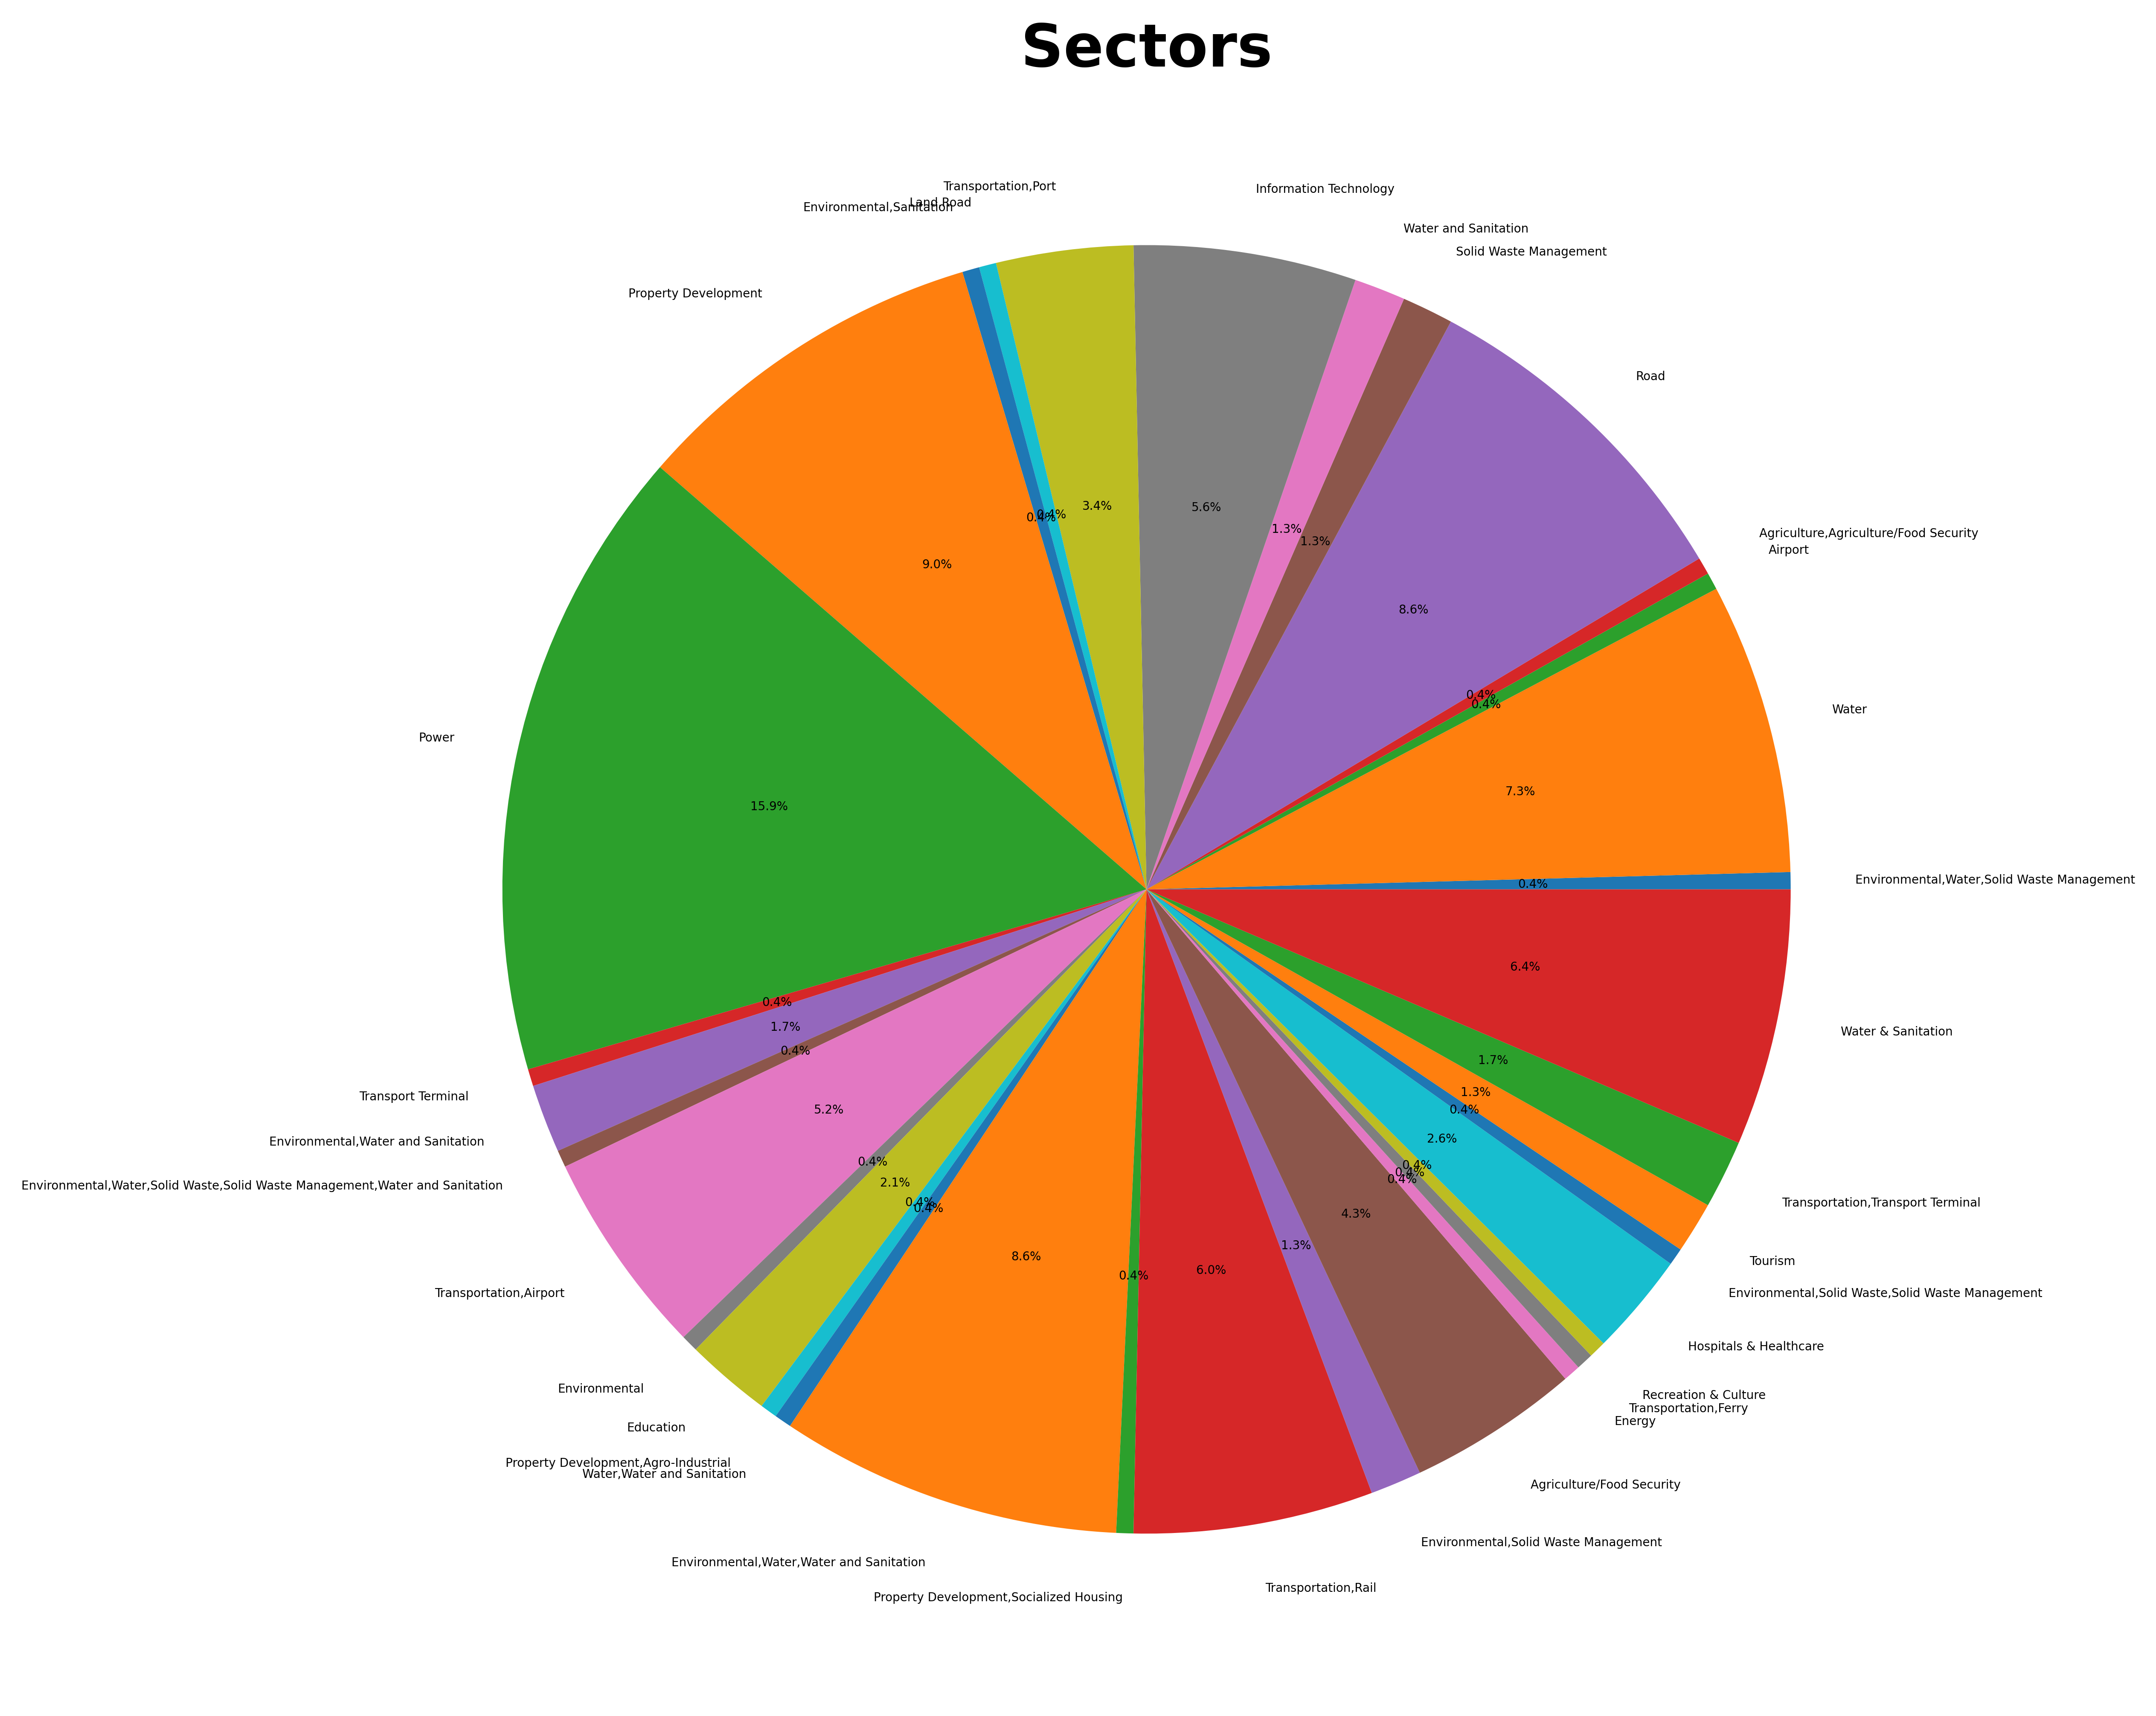

In [33]:
df= pd.DataFrame(graph_data)
sorted_category = list(set(df['Sector']))

pie_data=[]
for i in sorted_category:
    pie_data.append(len(df.loc[(df['Sector'] == i)]['Sector']))

plt.figure(figsize=(10,10),dpi=500)
plt.title('Sectors', fontdict={'fontweight':'bold','fontsize':20})
plt.savefig('Sectors.png',dpi=500)
plt.pie(pie_data, labels=sorted_category,textprops={'fontsize':4}, autopct='%1.1f%%')
plt.show()

In [34]:
sorted_category = list(set(df['Sector']))
pie_data=[]
for i in sorted_category:
    pie_data.append(len(df.loc[(df['Status'] == 'Operational') & (df['Sector'] == i)]['Sector']))
    
plt.figure(figsize=(25,25),dpi=500)
plt.title('Sectors Under Operational Status', fontdict={'fontweight':'bold','fontsize':40})
plt.savefig('Sectors Under Operational Status.png',dpi=1000)
plt.pie(pie_data,labels=sorted_category, textprops={'fontsize':10},autopct='%1.1f%%')
plt.show()

In [35]:
sorted_category = list(set(df['Sector']))
v1=[]
for i in sorted_category:
    v1.append(len(df.loc[(df['Status'] == "Completed/Concluded") & (df['Sector'] == i)]['Sector']))
    
plt.figure(figsize=(25,25),dpi=500)
plt.title("Sectors Under Completed/Concluded Status", fontdict={'fontweight':'bold','fontsize':40})
plt.pie(v1,labels=sorted_category, textprops={'fontsize':10},autopct='%1.1f%%')
plt.show()
#Clumped texts are 0%

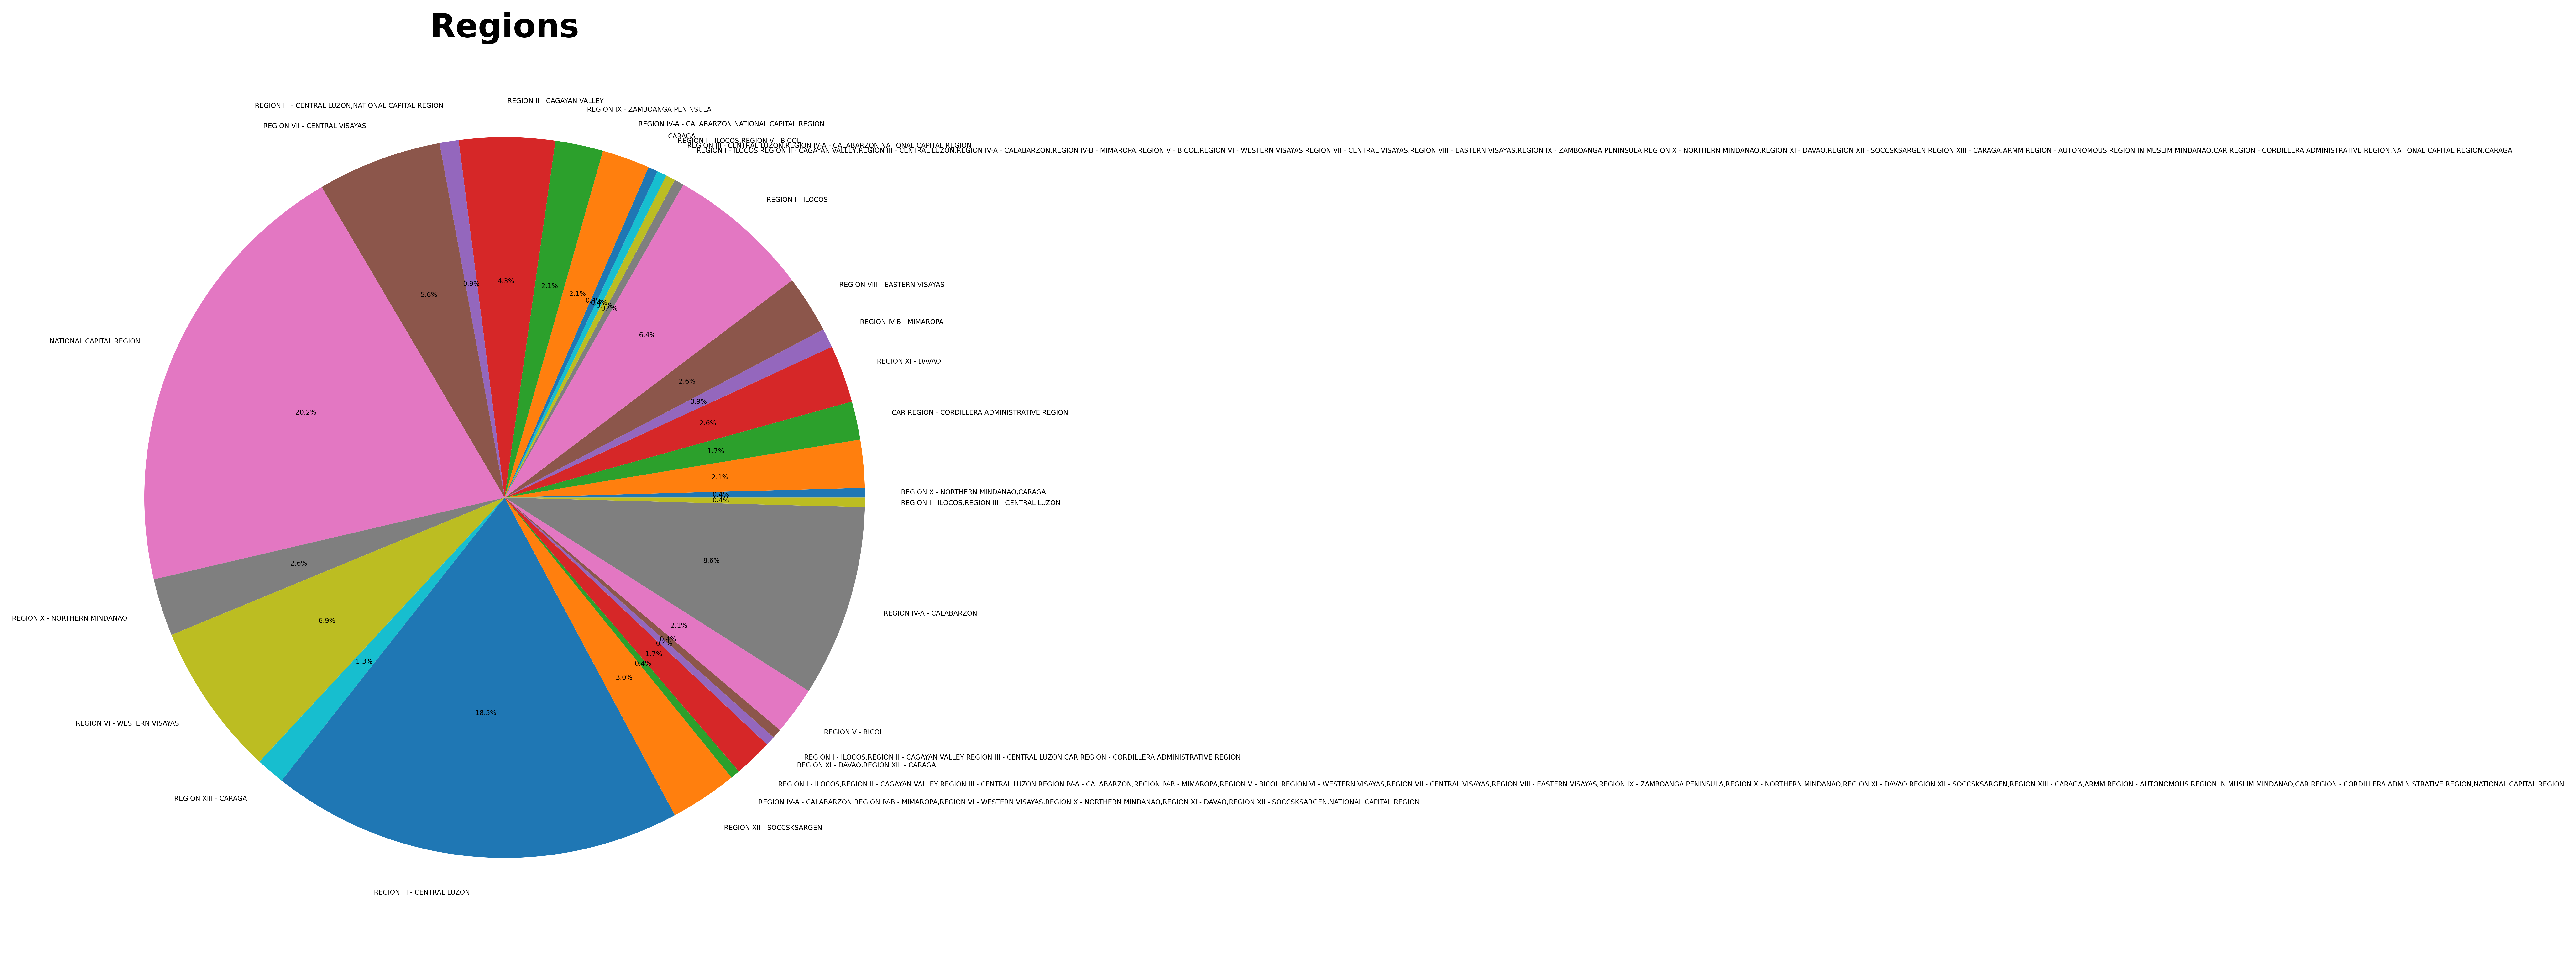

In [36]:
df= pd.DataFrame(graph_data)
sorted_category = list(set(df['Region']))

v2=[]
for i in sorted_category:
    v2.append(len(df.loc[(df['Region'] == i)]['Region']))

plt.figure(figsize=(10,10),dpi=500)
plt.title("Regions", fontdict={'fontweight':'bold','fontsize':20})
plt.savefig('Regions.png',dpi=500)
plt.pie(v2, labels=sorted_category, textprops={'fontsize':4},autopct='%1.1f%%')
plt.show()